In [1]:
from sympy import *
import numpy as np
import pandas as pd

from direct_lingam.simulate_data import get_Lambda, simulate_data
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)
import multiprocess as mp
# import torch.multiprocessing as mp

from models import CM

# One Latent Variable

Lambda is 
 [[0 0 0]
 [0 0 0]
 [0 1 0]]
Gamma is 
 [[1]
 [1]
 [1]]


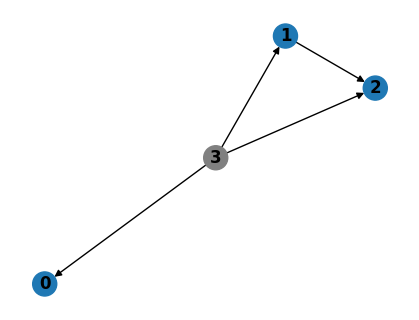

In [3]:

Lambda = get_Lambda([(2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1], [1], [1]])
print(f"Gamma is \n {Gamma}")
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [ ]:
import time
def run_experiment(seed):
    # run the experiment using the given parameters
    # Set the random seed
    print(f"Running experiment with seed {seed}")
    noise_distribution = 'gamma'
    samples_sizes = [10**n for n in range(1, 8, 2)]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]
    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]

    # Perform the experiment
    causal_effect_estimate = []
    cross_moment_causal_effect_estimate = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        model = CM(X_sample, highest_l=highest_l)
        causal_effect_estimate.append(model.estimate_effect())
        cross_moment_causal_effect_estimate.append(model.estimate_effect_cross_moment())

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Effect Estimate': causal_effect_estimate,
        'Cross Moment Effect Estimate': cross_moment_causal_effect_estimate,
    })
    return seed_df

def parallel_simulation(reps):
    pool = mp.Pool(mp.cpu_count())
    seeds = range(reps)
    results = pool.map(run_experiment, seeds)

    pool.close()
    return pd.concat(results, ignore_index=True)

results_df = parallel_simulation(100)

def add_grica_exp(results_df):

    samples_sizes = results_df['Sample Size'].unique()
    n_max = int(max(samples_sizes))
    noise_distribution = 'gamma'

    grica_causal_effect_estimate = []
    for seed in results_df['Seed'].unique():

        np.random.seed(seed)
        X, _ = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)

        for n in samples_sizes:
            X_sample = X[:int(n), :]
            X_sample = np.asfortranarray(X_sample)
            X_sample = X_sample - np.mean(X_sample, axis=0)

            model = CM(X_sample, highest_l=highest_l)
            print("GRICA with n = ", n)
            time_start = time.time()
            if n <= 10**5:
                ce_estimate = model.estimate_effect_grica().item()
            grica_causal_effect_estimate.append(ce_estimate)
            print("Time taken: ", time.time()-time_start)

    results_df['GRICA Effect Estimate'] = grica_causal_effect_estimate
    return results_df

results_df = add_grica_exp(results_df)

In [5]:
results_df.to_csv('Data/cm_1_latent.csv', index=False)

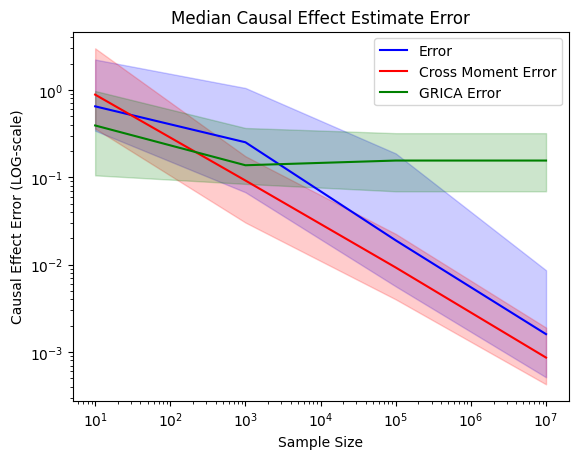

In [6]:

import matplotlib.pyplot as plt

results_df["Error"] = np.abs((results_df['Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["Cross Moment Error"] = np.abs((results_df['Cross Moment Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["GRICA Error"] = np.abs((results_df['GRICA Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error


# Group the results by sample size and calculate the mean
median_results = results_df.groupby('Sample Size').median()
quantile_results = results_df.groupby('Sample Size').quantile(0.25)
quantile_results2 = results_df.groupby('Sample Size').quantile(0.75)

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(median_results.index, median_results["Error"],
         label='Error',
         color = "blue")

plt.fill_between(median_results.index, quantile_results["Error"], quantile_results2["Error"], alpha=0.2, color = "blue")

plt.plot(median_results.index, median_results["Cross Moment Error"],
            label='Cross Moment Error',
            color = "red")

plt.fill_between(median_results.index, quantile_results["Cross Moment Error"], quantile_results2["Cross Moment Error"], alpha=0.2, color = "red")

plt.plot(median_results.index, median_results["GRICA Error"],
            label='GRICA Error',
            color = "green")

plt.fill_between(median_results.index, quantile_results["GRICA Error"], quantile_results2["GRICA Error"], alpha=0.2, color = "green")


plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Median Causal Effect Estimate Error')
plt.show()

# Two Latent Variables

Lambda is 
 [[0 0 0]
 [0 0 0]
 [0 1 0]]
Gamma is 
 [[1 1]
 [1 1]
 [1 1]]


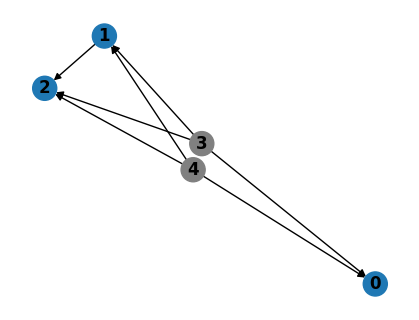

In [6]:
Lambda = get_Lambda([(2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1, 1], [1, 1], [1, 1]])
print(f"Gamma is \n {Gamma}")
highest_l = 2
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [ ]:
import time
def run_experiment(seed):
    # run the experiment using the given parameters
    # Set the random seed
    print(f"Running experiment with seed {seed}")
    noise_distribution = 'gamma'
    samples_sizes = [10**n for n in range(1, 8, 2)]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]
    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]

    # Perform the experiment
    causal_effect_estimate = []
    cross_moment_causal_effect_estimate = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        model = CM(X_sample, highest_l=highest_l)
        causal_effect_estimate.append(model.estimate_effect())
        cross_moment_causal_effect_estimate.append(model.estimate_effect_cross_moment())

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Effect Estimate': causal_effect_estimate,
        'Cross Moment Effect Estimate': cross_moment_causal_effect_estimate,
    })
    return seed_df

def parallel_simulation(reps):
    pool = mp.Pool(mp.cpu_count())
    seeds = range(reps)
    results = pool.map(run_experiment, seeds)

    pool.close()
    return pd.concat(results, ignore_index=True)

results_df_2_latents = parallel_simulation(100)

def add_grica_exp(results_df):

    samples_sizes = results_df['Sample Size'].unique()
    n_max = int(max(samples_sizes))
    noise_distribution = 'gamma'

    grica_causal_effect_estimate = []
    for seed in results_df['Seed'].unique():

        np.random.seed(seed)
        X, _ = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)

        for n in samples_sizes:
            X_sample = X[:int(n), :]
            X_sample = np.asfortranarray(X_sample)
            X_sample = X_sample - np.mean(X_sample, axis=0)

            model = CM(X_sample, highest_l=highest_l)
            print("GRICA with n = ", n)
            time_start = time.time()
            if n <= 10**5:
                ce_estimate = model.estimate_effect_grica().item()
            grica_causal_effect_estimate.append(ce_estimate)
            print("Time taken: ", time.time()-time_start)

    results_df['GRICA Effect Estimate'] = grica_causal_effect_estimate
    return results_df

results_df_2_latents = add_grica_exp(results_df_2_latents)

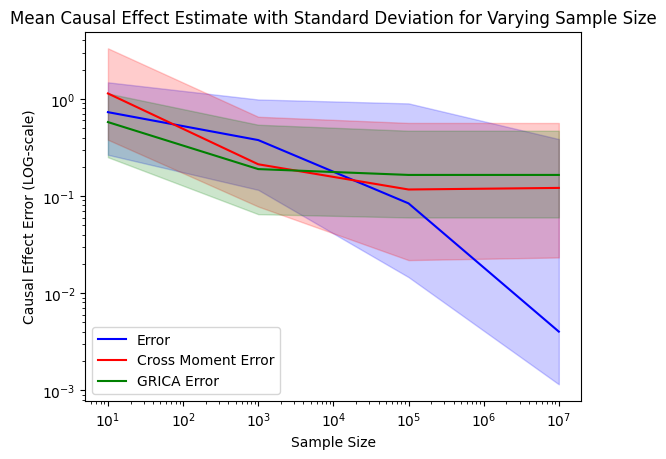

In [18]:
import matplotlib.pyplot as plt

results_df_2_latents["Error"] = np.abs((results_df_2_latents['Effect Estimate'] - results_df_2_latents["True Effect"])/results_df_2_latents["True Effect"])  # Calculate the error
results_df_2_latents["Cross Moment Error"] = np.abs((results_df_2_latents['Cross Moment Effect Estimate'] - results_df_2_latents["True Effect"])/results_df_2_latents["True Effect"])  # Calculate the error
results_df_2_latents["GRICA Error"] = np.abs((results_df_2_latents['GRICA Effect Estimate'] - results_df_2_latents["True Effect"])/results_df_2_latents["True Effect"])  # Calculate the error


# Group the results by sample size and calculate the mean
median_results = results_df_2_latents.groupby('Sample Size').median()
quantile_results = results_df_2_latents.groupby('Sample Size').quantile(0.25)
quantile_results_75 = results_df_2_latents.groupby('Sample Size').quantile(0.75)
mean_sd = results_df_2_latents.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(median_results.index, median_results["Error"],
         label='Error',
         color = "blue")

plt.fill_between(median_results.index, quantile_results["Error"], quantile_results_75["Error"], color = "blue", alpha = 0.2)
plt.plot(median_results.index, median_results["Cross Moment Error"],
            label='Cross Moment Error',
            color = "red")

plt.fill_between(median_results.index, quantile_results["Cross Moment Error"], quantile_results_75["Cross Moment Error"], color = "red", alpha = 0.2)
plt.plot(median_results.index, median_results["GRICA Error"],
            label='GRICA Error',
            color = "green")

plt.fill_between(median_results.index, quantile_results["GRICA Error"], quantile_results_75["GRICA Error"], color = "green", alpha = 0.2)


plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Median Causal Effect Estimate Error')
plt.show()

In [10]:
results_df_2_latents.to_csv('Data/cm_2_latent.csv', index=False)